## Support vector machine on an offshore field historic production data

### Source: https://data-equinor-com.azurewebsites.net/dataset/volve

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import scipy
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\aath\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Load the data
path1 = ("C:/Users/aath/Dropbox/MAEN/Thankful/Data/STO/volve_day_prod.csv")
original_data = pd.read_csv(path1, thousands=',')

In [4]:
# Create a date index
original_data['DATETIME'] = pd.to_datetime(original_data['DATEPRD'])
original_data = original_data.set_index('DATETIME')
original_data = original_data.drop(['DATEPRD'], axis=1)

In [5]:
# Checks column names
list(original_data.columns)

['WELL_BORE_CODE',
 'NPD_WELL_BORE_CODE',
 'NPD_WELL_BORE_NAME',
 'NPD_FIELD_CODE',
 'NPD_FIELD_NAME',
 'NPD_FACILITY_CODE',
 'ON_STREAM_HRS',
 'AVG_DOWNHOLE_PRESSURE',
 'AVG_DOWNHOLE_TEMPERATURE',
 'AVG_DP_TUBING',
 'AVG_ANNULUS_PRESS',
 'AVG_CHOKE_SIZE_P',
 'AVG_CHOKE_UOM',
 'AVG_WHP_P',
 'AVG_WHT_P',
 'DP_CHOKE_SIZE',
 'BORE_OIL_VOL',
 'BORE_GAS_VOL',
 'BORE_WAT_VOL',
 'BORE_WI_VOL',
 'FLOW_KIND',
 'WELL_TYPE',
 'BOEPD_PRODUCED_VOL',
 'PROD_NXT_12_MO']

In [6]:
# Check the data type of each column by groupby
original_data.columns.to_series().groupby(original_data.dtypes).groups

{dtype('int64'): Index(['NPD_WELL_BORE_CODE', 'NPD_FIELD_CODE', 'NPD_FACILITY_CODE',
        'PROD_NXT_12_MO'],
       dtype='object'),
 dtype('float64'): Index(['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
        'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P',
        'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL',
        'BORE_WAT_VOL', 'BORE_WI_VOL', 'BOEPD_PRODUCED_VOL'],
       dtype='object'),
 dtype('O'): Index(['WELL_BORE_CODE', 'NPD_WELL_BORE_NAME', 'NPD_FIELD_NAME',
        'AVG_CHOKE_UOM', 'FLOW_KIND', 'WELL_TYPE'],
       dtype='object')}

In [7]:
original_data["BORE_GAS_VOL"].head(20)

DATETIME
2014-04-07         0.0
2014-04-08         0.0
2014-04-09         0.0
2014-04-10         0.0
2014-04-11         0.0
2014-04-12         0.0
2014-04-13         0.0
2014-04-14         0.0
2014-04-15         0.0
2014-04-16         0.0
2014-04-17         0.0
2014-04-18         0.0
2014-04-19         0.0
2014-04-20         0.0
2014-04-21         0.0
2014-04-22     90439.0
2014-04-23    165720.0
2014-04-24    221707.0
2014-04-25    178064.0
2014-04-26    192602.0
Name: BORE_GAS_VOL, dtype: float64

In [8]:
# Count nulls
null_count = original_data.isnull().sum()
null_count[null_count>0]

ON_STREAM_HRS                285
AVG_DOWNHOLE_PRESSURE       6654
AVG_DOWNHOLE_TEMPERATURE    6654
AVG_DP_TUBING               6654
AVG_ANNULUS_PRESS           7744
AVG_CHOKE_SIZE_P            6715
AVG_CHOKE_UOM               6473
AVG_WHP_P                   6479
AVG_WHT_P                   6488
DP_CHOKE_SIZE                294
BORE_OIL_VOL                6473
BORE_GAS_VOL                6473
BORE_WAT_VOL                6473
BORE_WI_VOL                 9928
dtype: int64

In [9]:
# Fill NAs with zero
original_data = original_data.fillna(0)

In [10]:
# Drop not useful columns
original_data = original_data.drop(['NPD_FIELD_CODE','NPD_FIELD_NAME','NPD_FACILITY_CODE'], axis=1)

In [11]:
# Create cumulitive volumes
original_data['BORE_OIL_VOL_CUME']=original_data['BORE_OIL_VOL'].cumsum()
original_data['BORE_GAS_VOL_CUME']=original_data['BORE_GAS_VOL'].cumsum()
original_data['BORE_WAT_VOL_CUME']=original_data['BORE_WAT_VOL'].cumsum()
original_data['BOEPD_PRODUCED_CUME']=original_data['BOEPD_PRODUCED_VOL'].cumsum()

# Add a binary column showing if production BOEPD >= 3K
original_data['MIN_3K_BOEPD_BINARY'] = np.where(original_data['BOEPD_PRODUCED_VOL']  >= 3000, 1,0)

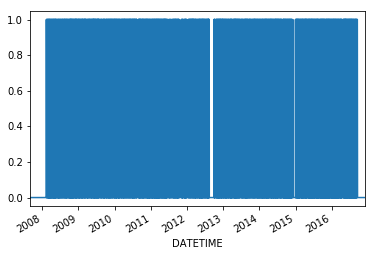

In [12]:
original_data['MIN_3K_BOEPD_BINARY'].plot()

In [13]:
# Crea x and y values

X=original_data[['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
                 'AVG_DP_TUBING','AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P',
                 'AVG_WHP_P','AVG_WHT_P', 'DP_CHOKE_SIZE']].copy()
y= original_data[['MIN_3K_BOEPD_BINARY']].copy()

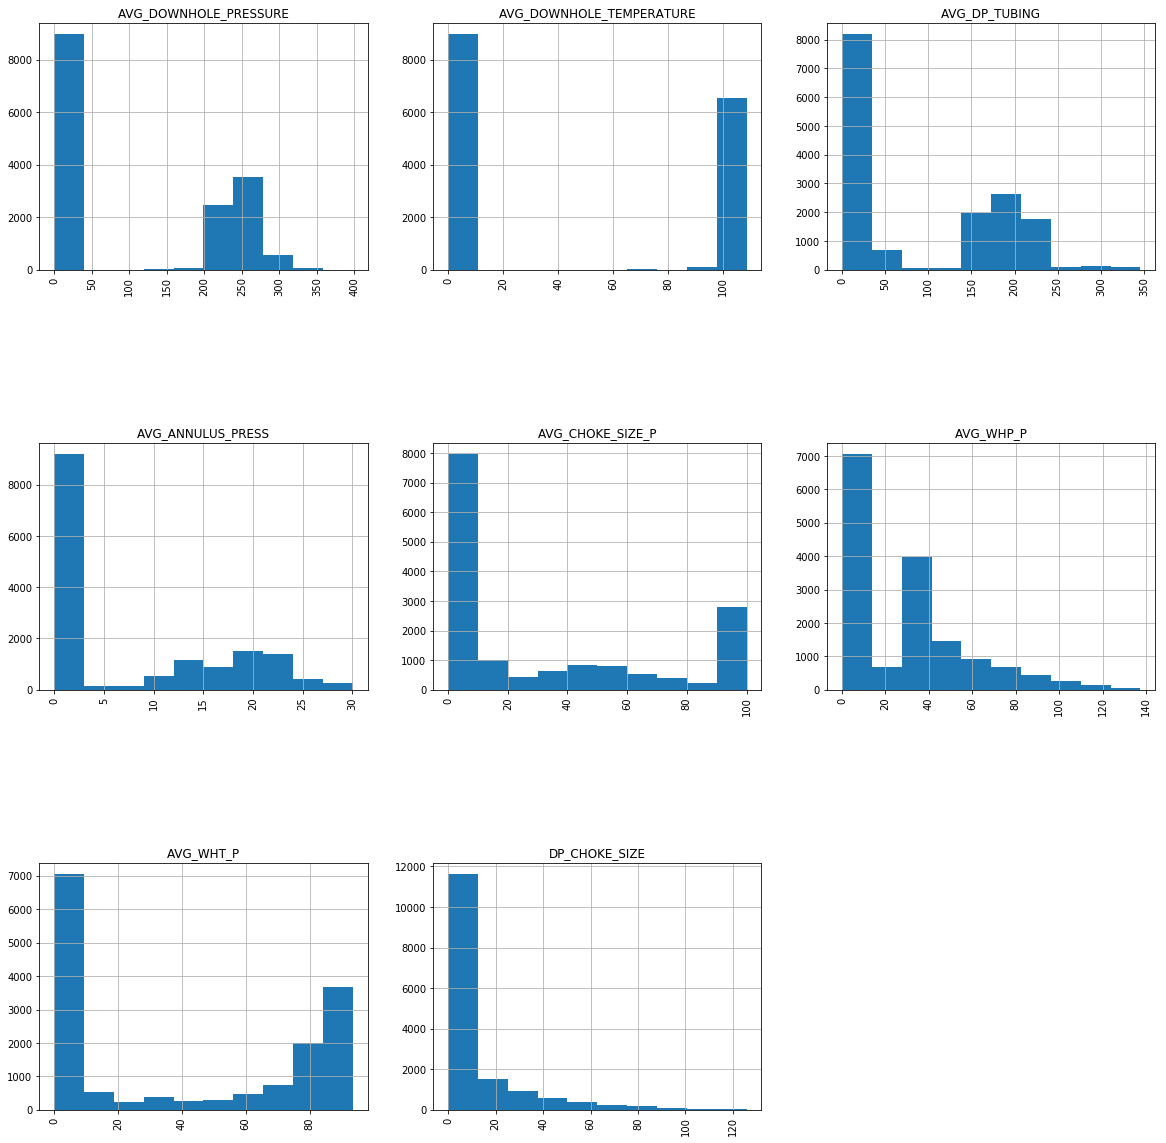

In [14]:
# 
fig = plt.figure(figsize=(20,20))
cols = 3
rows = math.ceil(float(X.shape[1]) / cols)

for i, column in enumerate(['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
                 'AVG_DP_TUBING','AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P',
                 'AVG_WHP_P','AVG_WHT_P', 'DP_CHOKE_SIZE']):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if X.dtypes[column] == np.object:
        X[column].value_counts().plot(kind="bar", axes=ax)
    else:
        X[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

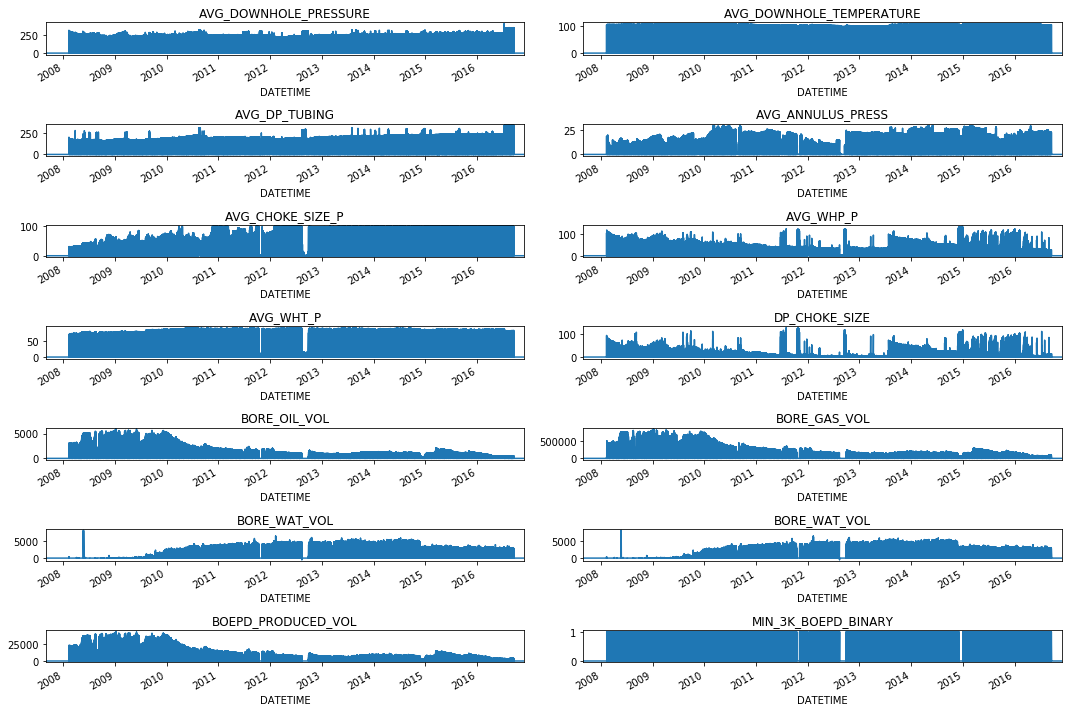

In [89]:
plt.figure(1)
plt.subplot(7,2,1)
original_data.AVG_DOWNHOLE_PRESSURE.plot( figsize=(15,10), title='AVG_DOWNHOLE_PRESSURE') 


plt.subplot(7,2,2)
original_data.AVG_DOWNHOLE_TEMPERATURE.plot( figsize=(15,10), title='AVG_DOWNHOLE_TEMPERATURE') 

plt.subplot(7,2,3)
original_data.AVG_DP_TUBING.plot( figsize=(15,10), title='AVG_DP_TUBING') 

plt.subplot(7,2,4)
original_data.AVG_ANNULUS_PRESS.plot( figsize=(15,10), title='AVG_ANNULUS_PRESS') 

plt.subplot(7,2,5)
original_data.AVG_CHOKE_SIZE_P.plot( figsize=(15,10), title='AVG_CHOKE_SIZE_P') 

plt.subplot(7,2,6)
original_data.AVG_WHP_P.plot( figsize=(15,10), title='AVG_WHP_P') 

plt.subplot(7,2,7)
original_data.AVG_WHT_P.plot( figsize=(15,10), title='AVG_WHT_P') 

plt.subplot(7,2,8)
original_data.DP_CHOKE_SIZE.plot( figsize=(15,10), title='DP_CHOKE_SIZE') 

plt.subplot(7,2,9)
original_data.BORE_OIL_VOL.plot( figsize=(15,10), title='BORE_OIL_VOL') 

plt.subplot(7,2,10)
original_data.BORE_GAS_VOL.plot( figsize=(15,10), title='BORE_GAS_VOL') 

plt.subplot(7,2,11)
original_data.BORE_WAT_VOL.plot( figsize=(15,10), title='BORE_WAT_VOL') 

plt.subplot(7,2,12)
original_data.BORE_WAT_VOL.plot( figsize=(15,10), title='BORE_WAT_VOL') 

plt.subplot(7,2,13)
original_data.BOEPD_PRODUCED_VOL.plot( figsize=(15,10), title='BOEPD_PRODUCED_VOL') 

plt.subplot(7,2,14)
original_data.MIN_3K_BOEPD_BINARY.plot( figsize=(15,10), title='MIN_3K_BOEPD_BINARY') 


plt.tight_layout()
plt.show()

In [16]:
# Create multi-step or sequence forecasting. Also, we are using past observations to forecast a sequence of 
# future observations

from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

x_data = series_to_supervised(X, 20)
x_data.head()

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var6(t-20),var7(t-20),var8(t-20),var1(t-19),var2(t-19),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
DATETIME,,,,,,,,,,,,,,,,,,,,,
2014-04-27,0.000,0.000,0.000,0.0,0.00000,0.000,0.00,0.000,0.000,0.000,...,65.724,56.148,240.736,108.054,159.899,0.0,50.29698,80.837,66.934,52.202
2014-04-28,0.000,0.000,0.000,0.0,1.00306,0.000,0.00,0.000,0.000,0.000,...,66.934,52.202,235.021,108.042,157.683,0.0,50.73588,77.338,67.848,48.708
2014-04-29,0.000,0.000,0.000,0.0,0.97901,0.000,0.00,0.000,0.000,0.000,...,67.848,48.708,232.744,107.988,156.795,0.0,50.11392,75.949,65.707,47.376
2014-04-30,0.000,0.000,0.000,0.0,0.54576,0.000,0.00,0.000,310.376,96.876,...,65.707,47.376,233.298,107.893,157.179,0.0,48.92679,76.118,62.796,47.611
2014-05-01,310.376,96.876,277.278,0.0,1.21599,33.098,10.48,33.072,303.501,96.923,...,62.796,47.611,231.089,107.877,156.399,0.0,48.93863,74.690,62.377,46.196


In [17]:
y_data = series_to_supervised(y,20)
y_data.head()


,var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
DATETIME,,,,,,,,,,,,,,,,,,,,,
2014-04-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1
2014-04-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2014-04-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2014-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2014-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [18]:
y_data = y_data.loc[:,'var1(t)']

In [19]:
y_data.head()

DATETIME
2014-04-27    1
2014-04-28    1
2014-04-29    1
2014-04-30    1
2014-05-01    1
Name: var1(t), dtype: int32

In [20]:
x_data.shape, y_data.shape

((15614, 168), (15614,))

In [21]:
from sklearn.model_selection import train_test_split

# Spliting into 80% for training set and 20% for testing set so we can see our accuracy
X_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=0)

In [22]:
from sklearn.svm import SVC   

# Declaring the SVC with no tuning
classifier = SVC()

# Fitting the data. This is where the SVM will learn
classifier.fit(X_train, y_train)

# Predicting the result and giving the accuracy
score = classifier.score(x_test, y_test)

print(score)

0.82004482869


In [23]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
 
svm_est = Pipeline([('scaler',StandardScaler()),('svc',OneVsRestClassifier(SVR()))])

In [24]:
# Create a parameter grid:
Cs = [0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1]
 
param_grid = dict(svc__estimator__gamma=gammas, svc__estimator__C=Cs)

In [27]:
# Perform a randomized search of the best hyperparameters, C and gamma

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
 
rand_grid = RandomizedSearchCV(svm_est, param_distributions=param_grid, cv=5,n_iter=5,scoring='neg_mean_absolute_error')
rand_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', OneVsRestClassifier(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          n_jobs=1))]),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'svc__estimator__gamma': [0.001, 0.01, 0.1], 'svc__estimator__C': [0.1, 1, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [28]:
# Look at the best parameters:
rand_grid.best_params_

{'svc__estimator__C': 1, 'svc__estimator__gamma': 0.01}

In [29]:
# Look at the best score:
rand_grid.best_score_

-0.036827497865072591

In [30]:
regressor = SVR (C = 10, epsilon=0.1, kernel='rbf')
regressor.fit(X_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [115]:
from sklearn.metrics import mean_squared_error, explained_variance_score 

# Evaluate performance of Support Vector Regressor 
y_test_pred = regressor.predict(x_test) 

mse = mean_squared_error(y_test, y_test_pred) 
evs = explained_variance_score(y_test, y_test_pred)  
print("\n#### Performance ####") 
print("Mean squared error =", round(mse, 2)) 
print("Explained variance score =", round(evs, 2)) 

#X_train, x_test, y_train, y_test


#### Performance ####
Mean squared error = 0.11
Explained variance score = 0.49


In [143]:
# Test the regressor on test datapoint 
#test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052] 
last_day_data = x_data.iloc[-100]
last_actual = y_data.iloc[-100]
print("\nPredicted production:", regressor.predict([last_day_data])) 
print("\n Actual production:")
last_actual



Predicted production: [ 0.10001512]

 Actual production:


0